# Rollover Planner

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
import time
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')

savepath = parentdir + '/data/'+time.strftime("%m_%d")+'/rollover/'
if not os.path.exists(savepath):
    os.makedirs(savepath)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from visualizer import VisualModel
from simulator import HumanoidSimulator
from simple_planner import SimpleKneePlanner
import pinocchio
print(pinocchio.__version__)
import numpy as np
pinocchio.switchToNumpyMatrix()

/home/jack/.local/lib/python2.7/site-packages/robot_properties_solo/config/package_config.ini
/home/jack/repos/humanoid/humanoid_property/urdf/humanoid.urdf
['/home/jack/repos/humanoid/humanoid_property']
2.5.6


###  1. Load model 
$x_0$, $n_q$, $n_v$, $n_a$

In [5]:
# Define simulation steps
horizon_length = 5000
time_step = 1e-3

# Define control trajectory steps 
ctrl_time_step = 8e-3
print('total simulation steps: %d, simulation time interval %.3f s'%(horizon_length, time_step))

total simulation steps: 5000, simulation time interval 0.001 s


In [6]:
# Load pinocchio model
m = VisualModel(display=False)
x0, nq, nv, na = m.x0, m.nq, m.nv, m.na
lower, upper = m.getLimit()
velLower, velUpper = m.getVelLimit()
torqueLower, torqueUpper = m.getTorqueLimit()
# x_input = m.q0[:3].copy()
# print(m.q0)
# [-0.02388] [-0.     ] [-0.15591]
# [ 0.00252] [-0.     ] [ 0.35367]
# print(0.00252-(-0.02388))
# print(0.35367-(-0.15591))

In [7]:
# model_state = m.model.defaultState
# from visualizer import ReferenceState
# state = ReferenceState(model_state)
# state.value['l_hip_y'] += np.pi/2
# state.weight['l_hip_y'] = 100.
# state.update()

In [8]:
# state1 = ReferenceState(model_state)
# state1.value = state.value
# state1.update()

### 2. Simple knee trajectory to initiate robot's movement

In [9]:
simpleKneePlanner = SimpleKneePlanner(x0, nq, nv, na, horizon_length)
kneeTraj = simpleKneePlanner.forward()

### 3. Simulate static trajectory to obtain handLength and initial pose

#### unplanned trajecotry

In [10]:
s = HumanoidSimulator(horizon_length, display=False, timeStep=time_step, view='left')
s.initPose(x0, nq, nv, na)
_, _, _, _,_, _, x1, handLength, timeLength, initCoM, initCoMv,initKneeAngle, peArr, keArr  = s.simulate(m, kneeTraj, kneeTraj)
ctrl_horizon_length = timeLength//int(ctrl_time_step/time_step)
print('fall simulated knots: %d'%(timeLength))
print('fall control knots: %d, control time interval %.3f s'%(ctrl_horizon_length, ctrl_time_step))
# print('ctrl_length:%d'%ctrl_horizon_length)
# print(ctrl_time_step, time_step)
# print(initCoM)
# print(initCoMv)
# print(initKneeAngle)
# print(handLength)
#ctrl_horizon_length-=9

CoM is pulled out of support polygon @ 1411
fall simulated knots: 367
fall control knots: 45, control time interval 0.008 s


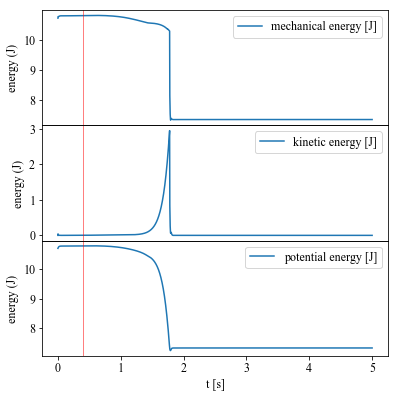

In [11]:
# Plot potential energy and kinematic energy
from utils import plotter
meArr = peArr + keArr
eArr = np.vstack([peArr, keArr])
eArr = np.vstack([eArr, meArr])

# eArr = eArr[:,2000:2500]
contactTime = 2400
drawer1 = plotter(eArr, v_line=[contactTime-2000],
        timeStep = 1e-3,
        legend=['potential energy [J]', 'kinetic energy [J]', 'mechanical energy [J]'], 
        xlabel='t [s]', 
        ylabel='energy (J)', 
        fileName=savepath+'static_energy.png')
drawer1.multiTimePlot(isVisiable=True)

In [12]:
# import pybullet as p
# p.disconnect()

In [13]:
from simulator import HumanoidSimulator
from simple_planner import SimpleHipPlanner

# To differentiate from bimanual, here we are using a hip planner
simpleHipPlanner = SimpleHipPlanner(x1, nq, nv, na, 100)
tauTraj = simpleHipPlanner.forward()

ss3 = HumanoidSimulator(horizon_length, display=False,timeStep=time_step, view='side')
ss3.initPose(x0, nq, nv, na)
forceArr, comArr, posArr,_, torqueArr, qArr, forcePose, tauArr, _, _, _, _ = ss3.simulateOptTraj(m, kneeTraj, tauTraj,ctrlTimeStep=ctrl_time_step)

action knot @ 1411, action time: 1411.00 ms
contact knot @ 1770, contact time: 1770.00 ms


In [14]:
rollover_hardware_simple_traj = ss3.toHardwareTraj(posArr)
np.savetxt(savepath+"rollover_value_simple.csv", rollover_hardware_simple_traj, delimiter=",")
# ss3.downloadTraj(savepath+"rollover_value_simple.csv")

original data columns: 5000
converted data columns: 1667


### 4. Optimize rollover trajectory

show handLength: posture difference between initial posture and final posture

In [15]:
print('target hand length in x direction %.3f'%handLength[0])
print('target hand length in y direction %.3f'%handLength[1])
print('target hand length in z direction %.3f'%handLength[2])

target hand length in x direction 0.135
target hand length in y direction -0.000
target hand length in z direction -0.362


*** SOLVE  ***
False
(1, 20)
action knot @ 1411, action time: 1411.00 ms
contact knot @ 1679, contact time: 1679.00 ms
current parameter: [ 37, 30, 11]
maximum force is 124.83 N


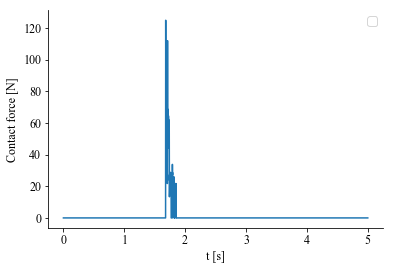

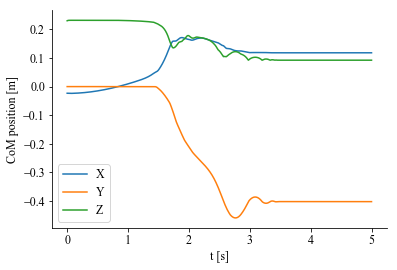

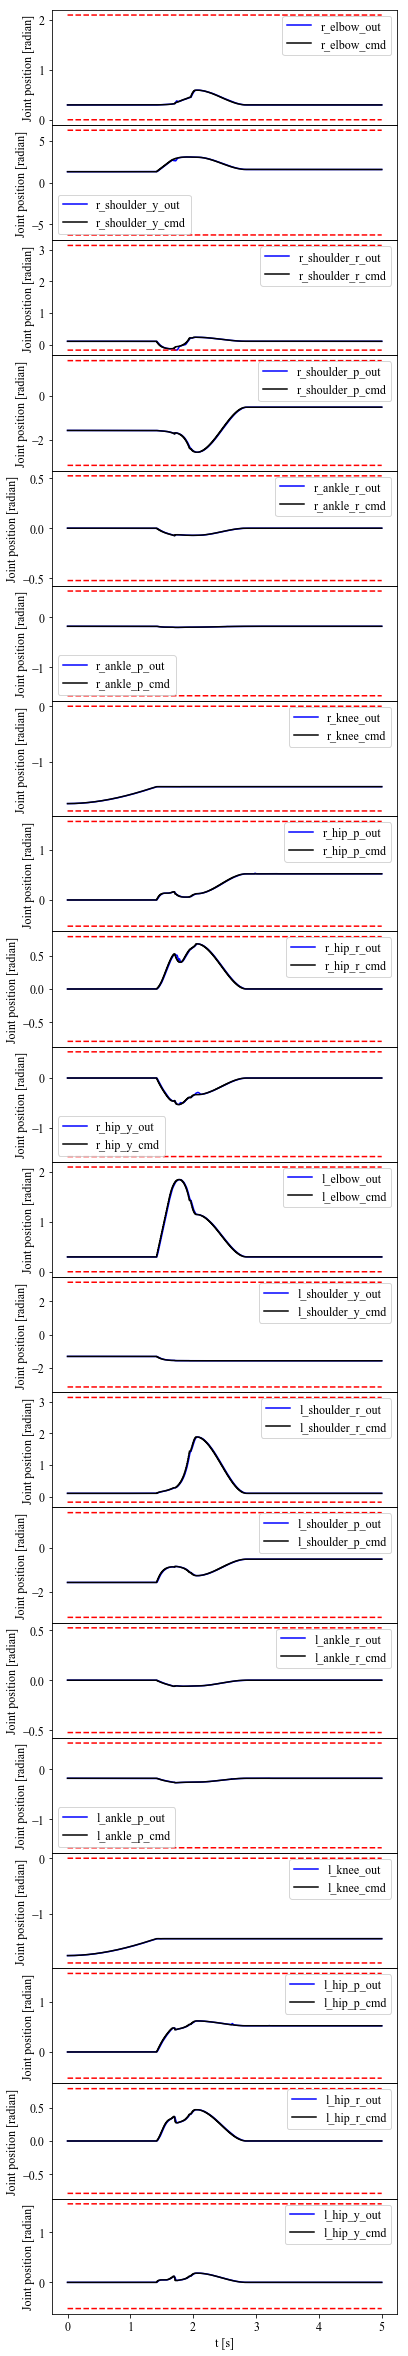

In [16]:
from simple_planner import SimpleKneePlanner
from rollover_planner import RolloverPlanner
from simulator import HumanoidSimulator
from simple_planner import SimpleRolloverTrajWrapper

timeLength = [37, 30, 11]
rolloverPlanner = RolloverPlanner(x1, nq, nv, na, ctrl_horizon_length, contact_index=0, timeStep=ctrl_time_step, display=False)
tauRolloverTraj, velTraj = rolloverPlanner.forward(m, handLength.copy(), timeLength)
tauRolloverTraj_index = rolloverPlanner.contact_index
# rolloverPlanner.saveTraj(np.matrix(tauRolloverTraj).T, savepath+'value.csv')
# rolloverPlanner.saveSwConfig(savepath+'equations.txt')
#           # print('rollover optimal trajectory length(columns): %d'%tauRolloverTraj.shape[1])

# We wrap up the trajectory by adding an additional trajectory
finish_ctrl_horizon_length = 100
simpleRolloverTrajWrapper = SimpleRolloverTrajWrapper(x0, nq, nv, na, finish_ctrl_horizon_length)
newtauRolloverTraj = simpleRolloverTrajWrapper.forward(tauRolloverTraj)

# Simulate optimal rollover trajectory
ss = HumanoidSimulator(horizon_length, display=True,timeStep=time_step, view='side')
ss.initPose(x0, nq, nv, na)
forceArr, comArr, posArr, velArr, torqueArr, qArr, forcePose, tauArr, peArr, keArr, contactTime, forceKnot = ss.simulateOptTraj(m, 
                                                               kneeTraj, 
                                                               newtauRolloverTraj,
                                                               ctrlTimeStep=ctrl_time_step,
                                                               speed=1.,videoPath=savepath)

print('current parameter: [ %d, %d, %d]'%(timeLength[0], timeLength[1], timeLength[2]))
print('maximum force is %.2f N'%np.amax(forceArr))

posInfo = []
posInfo.append(posArr)
posInfo.append(lower)
posInfo.append(upper)

simVelInfo = []
simVelInfo.append(velArr)
simVelInfo.append(velLower)
simVelInfo.append(velUpper)

ocVelInfo = []
ocVelInfo.append(velTraj)
ocVelInfo.append(velLower)
ocVelInfo.append(velUpper)

torqueInfo = []
torqueInfo.append(torqueArr)
torqueInfo.append(torqueLower)
torqueInfo.append(torqueUpper)

cmpInfo = []
cmpInfo.append(posArr)
cmpInfo.append(tauArr)
cmpInfo.append(lower)
cmpInfo.append(upper)

cmpInfo = []
cmpInfo.append(posArr)
cmpInfo.append(tauArr)
cmpInfo.append(lower)
cmpInfo.append(upper)

ss.plot(forceArr,comArr,posInfo, simVelInfo, ocVelInfo, torqueInfo,savepath, time_step, cmpInfo=cmpInfo)

In [ ]:
'''
Display result from HPC
'''
# from simple_planner import SimpleKneePlanner
# from rollover_planner import RolloverPlanner
# from simulator import HumanoidSimulator
# from simple_planner import SimpleRolloverTrajWrapper
# import json
# import pickle

# with open(savepath+'results_sorted.pkl', 'rb') as handle:
#     results_sorted = pickle.load(handle)


# def str2list(str1):
#     list1=json.loads(str1)
#     return list1
# def list2str(list1):
#     str1 = '_'.join(str(e) for e in list1)
#     return str1

# # results = [[39,12,21],
# #             [32,13,14],
# #             [37,19,18],
# #             [39,13,17],
# #             [38,16,18],
# #             [32,13,13],
# #             [39,13,16],
# #             [39,13,19],
# #             [37,20,18],
# #             [36,12,12]]
# for result in results_sorted:
#     timeLength = str2list(result[0])
#     rolloverPlanner = RolloverPlanner(x1, nq, nv, na, ctrl_horizon_length, contact_index=0, timeStep=ctrl_time_step, display=False)
#     tauRolloverTraj, velTraj = rolloverPlanner.forward(m, handLength.copy(), timeLength)
#     tauRolloverTraj_index = rolloverPlanner.contact_index
#     # rolloverPlanner.saveTraj(np.matrix(tauRolloverTraj).T, savepath+'value.csv')
#     # rolloverPlanner.saveSwConfig(savepath+'equations.txt')
#     #           # print('rollover optimal trajectory length(columns): %d'%tauRolloverTraj.shape[1])

#     # We wrap up the trajectory by adding an additional trajectory
#     finish_ctrl_horizon_length = 100
#     simpleRolloverTrajWrapper = SimpleRolloverTrajWrapper(x0, nq, nv, na, finish_ctrl_horizon_length)
#     newtauRolloverTraj = simpleRolloverTrajWrapper.forward(tauRolloverTraj)

#     # Simulate optimal rollover trajectory
#     ss = HumanoidSimulator(horizon_length, display=True,timeStep=time_step, view='side')
#     ss.initPose(x0, nq, nv, na)
#     forceArr, comArr, posArr, velArr, torqueArr, qArr, forcePose, tauArr, peArr, keArr, contactTime, forceKnot = ss.simulateOptTraj(m, 
#                                                                    kneeTraj, 
#                                                                    newtauRolloverTraj,
#                                                                    ctrlTimeStep=ctrl_time_step,
#                                                                    speed=1.,videoPath=savepath, videoName=list2str(timeLength))

#     print('current parameter: [ %d, %d, %d]'%(timeLength[0], timeLength[1], timeLength[2]))
#     print('maximum force is %.2f N'%np.amax(forceArr))

# posInfo = []
# posInfo.append(posArr)
# posInfo.append(lower)
# posInfo.append(upper)

# simVelInfo = []
# simVelInfo.append(velArr)
# simVelInfo.append(velLower)
# simVelInfo.append(velUpper)

# ocVelInfo = []
# ocVelInfo.append(velTraj)
# ocVelInfo.append(velLower)
# ocVelInfo.append(velUpper)

# torqueInfo = []
# torqueInfo.append(torqueArr)
# torqueInfo.append(torqueLower)
# torqueInfo.append(torqueUpper)

# cmpInfo = []
# cmpInfo.append(posArr)
# cmpInfo.append(tauArr)
# cmpInfo.append(lower)
# cmpInfo.append(upper)

# cmpInfo = []
# cmpInfo.append(posArr)
# cmpInfo.append(tauArr)
# cmpInfo.append(lower)
# cmpInfo.append(upper)

# ss.plot(forceArr,comArr,posInfo, simVelInfo, ocVelInfo, torqueInfo,savepath, time_step, cmpInfo=cmpInfo)

In [ ]:
import pybullet as p
p.disconnect()
print(np.shape(velTraj))

### 5. Simulate optimal trajectory

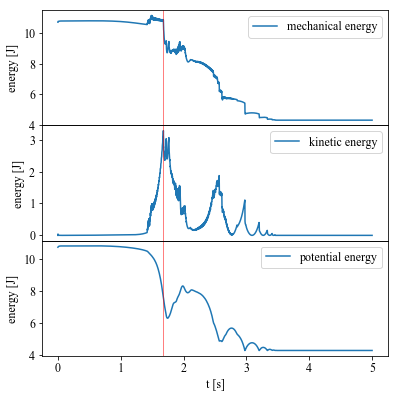

In [17]:
# Plot potential energy and kinematic energy
from utils import plotter
meArr = peArr + keArr
eArr = np.vstack([peArr, keArr])
eArr = np.vstack([eArr, meArr])

# start = 1000
# end = 2000

# eArr = eArr[:,start:end]
# contactTime = 2400
drawer1 = plotter(eArr, v_line=[contactTime],
        timeStep = 1e-3,
        legend=['potential energy', 'kinetic energy', 'mechanical energy'], 
        xlabel='t [s]', 
        ylabel='energy [J]', 
        fileName=savepath+'energy.png')
drawer1.multiTimePlot(isVisiable=True)

Compare control and simulation posture delay

In [ ]:
# savepath = parentdir + '/data/'+time.strftime("%m_%d")+'/bimanual/'
# # compare energy with bimanual strategy
# pe_filename = 'bimanual_optimal_value_pe.npy'
# ke_filename = 'bimanual_optimal_value_ke.npy'
# me_filename = 'bimanual_optimal_value_me.npy'
# bimanual_pe = np.load(savepath+pe_filename)
# bimanual_ke = np.load(savepath+ke_filename)
# bimanual_me = np.load(savepath+me_filename)

In [ ]:
# drawer = plotter(meArr[:,1000:], bimanual_me[:, 1000:], 
#         timeStep = 1e-3,
#         legend=['rollover mechanical energy'],
#         legend_cmp= ['bimanual mechanical energy'],
#         xlabel='t [s]', 
#         ylabel='energy [J]', 
#         fileName=savepath+'energy_cmp.png')
# drawer.cmpMultiTimePlot()

In [ ]:
rollover_hardware_traj = ss.toHardwareTraj(posArr)
timestr = time.strftime("%m_%d_%H_%M")
filename = 'rollover_value_'+timestr+'.csv'
filename_verify = 'rollover_value_'+timestr+'_verify.csv'
np.savetxt(savepath+filename, rollover_hardware_traj, delimiter=",")
np.savetxt(savepath+filename_verify, rollover_hardware_traj.T, delimiter=",")
# ss.downloadTraj(savepath+filename)

(71.21857485084614, 40.41896421485138)


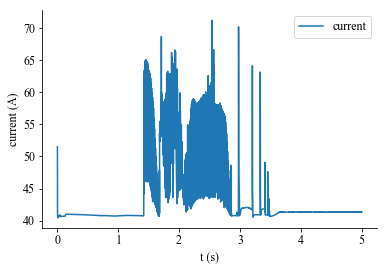

In [18]:
# Calculate summit torque
np.savetxt(savepath+"rollover_torque.csv", torqueArr, delimiter=",")

len = np.shape(torqueArr)[1]
currentArr = np.zeros([20, len])

def t2c28(x):
    # return math.sqrt(x)
    return 0.9286*x-0.05
def t2c64(x):
    return 0.875*x+0.1375
def t2c106(x):
    return 0.833*x-0.75

t2c28_v = np.vectorize(t2c28)
t2c64_v = np.vectorize(t2c64)
t2c106_v = np.vectorize(t2c106)

# l_hip_y
currentArr[0,:] = 4.1* np.ones([len])
currentArr[10,:] = 4.1* np.ones([len])
for i in range(1, 6):
    currentArr[i,:] = 5.2* np.ones([len])
    if i+10 == 11:
        currentArr[i+10,:] = 5.2* np.ones([len])
    else:
        currentArr[i+10,:] = np.absolute(t2c64_v(torqueArr[i+10,:]))
for i in range(6, 8):
    currentArr[i,:] = np.absolute(t2c64_v(torqueArr[i,:]))
    currentArr[i+10,:] = np.absolute(t2c64_v(torqueArr[i+10,:]))
for i in range(8, 10):
    currentArr[i,:] = np.absolute(t2c28_v(torqueArr[i,:]))
    currentArr[i+10,:] = np.absolute(t2c28_v(torqueArr[i+10,:]))

currentSum = np.sum(currentArr, axis=0)
currentSumArr = np.zeros([1,len])
currentSumArr[0,:] = currentSum

print(np.max(currentSum),np.min(currentSum))
from utils import plotter

drawer1 = plotter(currentSumArr, 
        timeStep = 1e-3,
        legend=['current'], 
        xlabel='t (s)', 
        ylabel='current (A)', 
        fileName=savepath+'current.png')
drawer1.timePlot()

visualize contact pose

In [ ]:
# m.visualizeConfig(forcePose)

Plot simulated result

do following command before screen capture

`sudo update-alternatives --config python3`

In [ ]:
# from simulator import HumanoidSimulator
# from simple_planner import SimpleRolloverTrajWrapper

# rollover trajectory replay

In [ ]:
# # replay encoder trajectory
# ENCODER_DIR=savepath + '09_25_1/desired_trajectory.csv'

# sss = HumanoidSimulator(horizon_length, display=True,timeStep=time_step, view='side')
# sss.initPose(x0, nq, nv, na)

# forceArr, comArr, posArr, torqueArr, qArr, forcePose, tauArr, peArr, keArr, contactTime, motorEArr, velArr= sss.replayEncoder(m,ENCODER_DIR, DIR=savepath)
# meArr = peArr + keArr
# np.savetxt(savepath+"09_25_1/force_array_rollover.csv", forceArr.T, delimiter=",")
# np.savetxt(savepath+"09_25_1/com_array_rollover.csv", comArr.T, delimiter=",")
# np.savetxt(savepath+"09_25_1/motor_energy_array_rollover.csv", motorEArr.T, delimiter=",")
# np.savetxt(savepath+"09_25_1/mechanical_energy_array_rollover.csv", meArr.T, delimiter=",")

# bimanual trajectory replay

In [ ]:
# # replay encoder trajectory
# ENCODER_DIR=savepath + '09_25_2/desired_trajectory.csv'

# sss = HumanoidSimulator(horizon_length, display=False,timeStep=time_step, view='side')
# sss.initPose(x0, nq, nv, na)
# forceArr, comArr, posArr, torqueArr, qArr, forcePose, tauArr, peArr, keArr, contactTime, motorEArr, velArr = sss.replayEncoder(m,ENCODER_DIR, DIR=savepath)
# meArr = peArr + keArr
# np.savetxt(savepath+"09_25_2/force_array_bimanual.csv", forceArr.T, delimiter=",")
# np.savetxt(savepath+"09_25_2/com_array_bimanual.csv", comArr.T, delimiter=",")
# np.savetxt(savepath+"09_25_2/motor_energy_array_bimanual.csv", motorEArr.T, delimiter=",")
# np.savetxt(savepath+"09_25_2/mechanical_energy_array_bimanual.csv", meArr.T, delimiter=",")

In [ ]:
# # Plot potential energy and kinematic energy
# from utils import plotter
# eArr = np.vstack([peArr, keArr])
# eArr = np.vstack([eArr, meArr])
# eArr = np.vstack([eArr, motorEArr])
# # print(peArr[0,forceKnot], keArr[0,forceKnot])
# # print(peArr[0,contactTime-1], keArr[0,contactTime-1])
# # eArr = eArr[:,2000:2500]

# drawer1 = plotter(eArr, v_line=[contactTime],
#         timeStep = 1e-3,
#         label=['potential energy', 'kinetic energy', 'mechanical energy', 'motor injection energy'], 
#         xlabel='t (s)', 
#         ylabel='energy (J)', 
#         fileName=savepath+'energy.png')
# drawer1.multiTimePlot()

In [ ]:
# posInfo = []
# posInfo.append(velArr)
# posInfo.append(lower)
# posInfo.append(upper)

# torqueInfo = []
# torqueInfo.append(torqueArr)
# torqueInfo.append(torqueLower)
# torqueInfo.append(torqueUpper)

# cmpInfo = []
# cmpInfo.append(posArr)
# cmpInfo.append(tauArr)
# cmpInfo.append(lower)
# cmpInfo.append(upper)

# sss.plot(forceArr,comArr,posInfo, torqueInfo,savepath, time_step, cmpInfo=cmpInfo)

### Generate Solidwork config files

In [ ]:
# q = qArr[:,1800]
# m.visualizeConfig(q)
# np.savetxt(savepath+"config_rollover.csv", q, delimiter=",")


In [ ]:

# from simple_planner import SimpleKneePlanner
# from rollover_planner import RolloverPlanner
# print(rolloverPlanner.x[:,-1])
# print(x0.T.tolist()[0])
# rolloverPlanner.saveConfig(x0.T.tolist()[0],savepath+'kneeling_config.xlsx')
# print(x0.shape)
# m.visualizeConfig(x0[:nq])

# rolloverPlanner.readConfig(savepath+'config.xlsx')


In [ ]:
# from pinocchio.rpy import matrixToRpy, rpyToMatrix, rotate

In [ ]:
# m = rotate('z', np.pi /3).dot(rotate('y', np.pi / 5)).dot(rotate('x', np.pi / 7))
# print(np.pi/3,np.pi/5,np.pi/7)
# print(m)
# print(matrixToRpy(m))

In [ ]:
# rpy = np.array(list(range(3))) * np.pi / 2

In [ ]:
# rpyToMatrix(rpy)

In [ ]:
# matrixToRpy(rpyToMatrix(rpy))

In [ ]:
# matrixToRpy(m)

In [ ]:
# rpyToMatrix(matrixToRpy(m))

In [ ]:
# from visualizer import VisualModel
# pinocchio.switchToNumpyMatrix()
# v = VisualModel(display=True)
# x = v.q0.T.tolist()[0]
# print(rolloverPlanner.x[:,-1])

# rolloverPlanner.saveConfig(x,savepath+'kneeling_config.xlsx')
# v.q0 = np.matrix(rolloverPlanner.x[:,-1]).T
# v.q0[0] = 0.
# v.q0[1] = 0
# v.q0[2] = 0
# v.show()
# x = v.q0.T.tolist()[0]
# rolloverPlanner.saveConfig(x,savepath+'kneeling_config.xlsx')
# quat = np.asarray(v.q0[3:7].copy()).tolist()
# print(quat)
# # Convert quaternion to rpy
# vector = np.matrix([0, 0, 0, quat[0][0], quat[1][0], quat[2][0], quat[3][0]]).T
# print(vector)
# se3 = pinocchio.XYZQUATToSE3(vector)
# rpy = matrixToRpy(se3.rotation)
# print(rpy)


In [ ]:
# m = rotate('z', np.pi /2).dot(rotate('y', np.pi / 100)).dot(rotate('x', np.pi /3))
# print(np.pi/3,np.pi/5,np.pi/7)
# print(m)
# print(matrixToRpy(m))

# n = pinocchio.SE3.Identity()
# n.rotation = m
# o = pinocchio.SE3ToXYZQUAT(n)
# print(o)
# # v.q0[3:7]=o[3:7]
# # v.q0[0] -= 0.02639
# # v.q0[1] -= 0.
# # v.q0[2] -= 0.50958
# v.q0[0] = 0.0
# v.q0[1] = 0.
# v.q0[2] = 0.0
# v.show()
# v.show()


# quat = np.asarray(v.q0[3:7].copy()).tolist()
# print(quat)
# # Convert quaternion to rpy
# vector = np.matrix([0, 0, 0, quat[0][0], quat[1][0], quat[2][0], quat[3][0]]).T
# print(vector)
# se3 = pinocchio.XYZQUATToSE3(vector)
# rpy = matrixToRpy(se3.rotation)
# print(rpy)



In [ ]:
# import crocoddyl
# print(crocoddyl.__file__)